In [155]:
import numpy as np
from simtk import unit as unit
import networkx as nx
import matplotlib.pyplot as plt

# Test kinnetic networks with contacts

In [15]:
def Hyd_file_parser(filename):
    init=False
    contacts_traj = []
    contacts_dict = {}
    n_contacts = 0
    with open(filename, 'r') as fff:
        for line in fff.readlines():
            if line.startswith('==='):
                if init:
                    contacts_traj.append(contacts_frame)
                contacts_frame = []
                init=True
            if line.startswith('  to'):
                words = line.split()
                resid = words[2]+'-'+words[4]+'/'+words[3]
                n_interactions = int(words[6])
                strength = float(words[-1])
                contact_label = 'GBC-985/A_'+resid
                try:
                    contact_index = contacts_dict[contact_label]
                except:
                    contact_index = n_contacts
                    contacts_dict[contact_label] = contact_index
                    n_contacts += 1
                contacts_frame.append([contact_index, n_interactions, strength])
    return contacts_traj, contacts_dict

In [16]:
def HB_file_parser(filename):
    init=False
    contacts_traj = []
    contacts_dict = {}
    n_contacts = 0
    with open(filename, 'r') as fff:
        for line in fff.readlines():
            if line.startswith('==='):
                if init:
                    contacts_traj.append(contacts_frame)
                contacts_frame = []
                init=True
            if line.startswith('Atom'):
                words = line.split()
                donor = words[1]+'/'+words[2]+'-'+words[3]+'/'+words[4]
                acceptor = words[9]+'/'+words[10]+'-'+words[11]+'/'+words[12][0]
                contact_label = donor+'_'+acceptor
                try:
                    contact_index = contacts_dict[contact_label]
                except:
                    contact_index = n_contacts
                    contacts_dict[contact_label] = contact_index
                    n_contacts += 1
                distance = float(words[17])*unit.angstroms
                energy = float(words[22])*unit.kilojoules_per_mole
                contacts_frame.append([contact_index, distance, energy])
    return contacts_traj, contacts_dict

In [17]:
files_HBs = ['HB_pose'+str(ii)+'.txt' for ii in range(1,7)] + ['HB_sfg.txt']
files_Hyd = ['Hyd_pose'+str(ii)+'.txt' for ii in range(1,7)] + ['Hyd_sfg.txt']
dir_path = 'contactos'
files_per_traj = [[dir_path+'/'+ii, dir_path+'/'+jj] for ii,jj in zip(files_HBs, files_Hyd)]

In [19]:
contacts_per_traj = []
for files in files_per_traj:
    file_HB, file_Hyd = files
    contacts_traj_HB, contacts_dict_HB = HB_file_parser(file_HB)
    contacts_traj_Hyd, contacts_dict_Hyd = Hyd_file_parser(file_Hyd)
    contacts_per_traj.append([contacts_traj_HB, contacts_dict_HB,
                             contacts_traj_Hyd, contacts_dict_Hyd])

## With out thresholds

In [119]:
# Building microstates with a unique dictionary for all trajectories

dict_u_HB = {}
dict_u_Hyd = {}
contacts_u_traj = []

dict_mss = {}
mss_traj = []
n_msss = 0

n_labels_HB = 0
n_labels_Hyd = 0

for contacts_traj in contacts_per_traj:
    contacts_HB, dict_HB, contacts_Hyd, dict_Hyd = contacts_traj
    dict_inv_HB = {jj:ii for ii,jj in dict_HB.items()}
    dict_inv_Hyd = {jj:ii for ii,jj in dict_Hyd.items()}
    for label in dict_HB:
        if label not in dict_u_HB:
            dict_u_HB[label] = n_labels_HB
            n_labels_HB += 1
    for label in dict_Hyd:
        if label not in dict_u_Hyd:
            dict_u_Hyd[label] = n_labels_Hyd
            n_labels_Hyd += 1
    contacts_u_HB = []
    contacts_u_Hyd = []
    for contacts in contacts_HB:
        aux = []
        for contact in contacts:
            contact_index = contact[0]
            distance = contact[1]
            energy = contact[2]
            contact_label = dict_inv_HB[contact_index]
            aux.append([dict_u_HB[contact_label], distance, energy])
        contacts_u_HB.append(aux)
    for contacts in contacts_Hyd:
        aux = []
        for contact in contacts:
            contact_index = contact[0]
            n_interactions = contact[1]
            strength = contact[2]
            contact_label = dict_inv_Hyd[contact_index]
            aux.append([dict_u_Hyd[contact_label], n_interactions, strength])
        contacts_u_Hyd.append(aux)
    contacts_u_traj.append([contacts_u_HB, contacts_u_Hyd])

for traj in contacts_u_traj:
    aux = []
    traj_HB = traj[0]
    traj_Hyd = traj[1]
    for frame in zip(traj_HB, traj_Hyd):
        frame_HB = frame[0]
        frame_Hyd = frame[1]
        contact_indices_HB = np.sort([ii[0] for ii in frame_HB])
        contact_indices_Hyd = np.sort([ii[0] for ii in frame_Hyd])
        mss_HB = ','.join([str(ii) for ii in contact_indices_HB])
        mss_Hyd = ','.join([str(ii) for ii in contact_indices_Hyd])
        mss = mss_HB+'-'+mss_Hyd
        try:
            mss_index = dict_mss[mss]
        except:
            mss_index = n_msss
            dict_mss[mss] = mss_index
            n_msss+=1
        aux.append(mss_index)
    mss_traj.append(np.array(aux))

In [120]:
unique_mss_traj=[]
for ii in range(7):
    unique_mss_traj.append(set(np.unique(mss_traj[ii])))

for ii in range(7):
    for jj in range(7):
        mss_intersect = unique_mss_traj[ii].intersection(unique_mss_traj[jj])
        if len(mss_intersect)>0 and ii!=jj:
            print(ii,jj)

In [136]:
networks = []
for ii in range(7):
    G = nx.DiGraph()
    G.add_nodes_from(unique_mss_traj[ii])
    for jj in G.nodes:
        G.nodes[jj]['weight']=0
    for jj in range(len(mss_traj[ii])-1):
        a = mss_traj[ii][jj]
        b = mss_traj[ii][jj+1]
        G.nodes[a]['weight']+=1
        try:
            G.edges[a, b]["weight"] += 1
        except:
            G.add_edge(a, b, weight=1)
    G.nodes[b]['weight']+=1
    networks.append(G)

In [151]:
for ii in range(7):
        weightest_nodes = [(u, d) for (u, d) in networks[ii].nodes(data=True) if d["weight"] > 10]
        print(weightest_nodes)

[(115, {'weight': 15}), (184, {'weight': 17}), (278, {'weight': 12}), (394, {'weight': 12}), (437, {'weight': 18}), (451, {'weight': 12}), (456, {'weight': 11})]
[(846, {'weight': 13}), (874, {'weight': 27}), (893, {'weight': 27}), (919, {'weight': 11}), (934, {'weight': 12}), (936, {'weight': 11}), (962, {'weight': 30}), (977, {'weight': 14})]
[(1395, {'weight': 14}), (1559, {'weight': 23})]
[(2568, {'weight': 11})]
[(2636, {'weight': 17}), (2824, {'weight': 11})]
[(3444, {'weight': 43}), (3454, {'weight': 16}), (3456, {'weight': 38}), (3459, {'weight': 14}), (3465, {'weight': 75}), (3466, {'weight': 12}), (3467, {'weight': 12}), (3494, {'weight': 28}), (3497, {'weight': 13}), (3502, {'weight': 53}), (3504, {'weight': 96}), (3505, {'weight': 25}), (3508, {'weight': 20}), (3509, {'weight': 37}), (3513, {'weight': 13}), (3516, {'weight': 13}), (3542, {'weight': 20}), (3544, {'weight': 19})]
[(3833, {'weight': 11}), (3855, {'weight': 12}), (3856, {'weight': 14}), (3859, {'weight': 11}), 

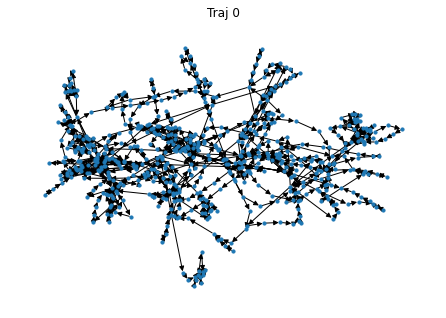

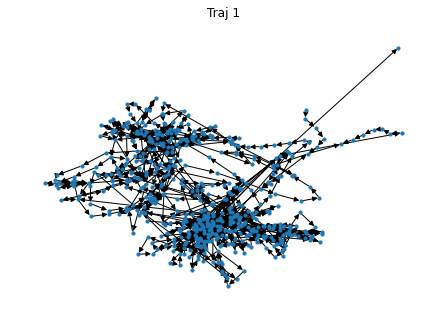

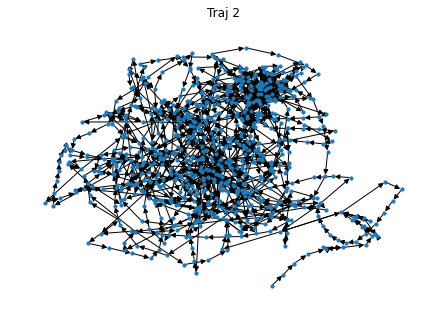

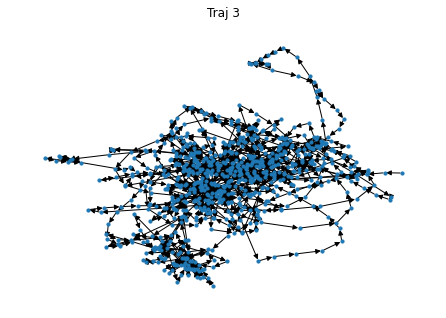

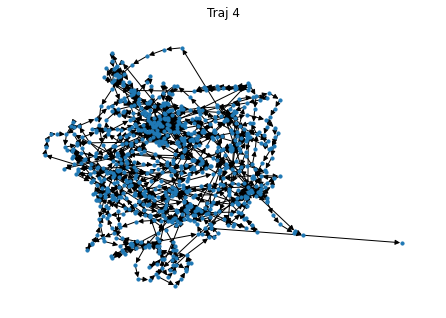

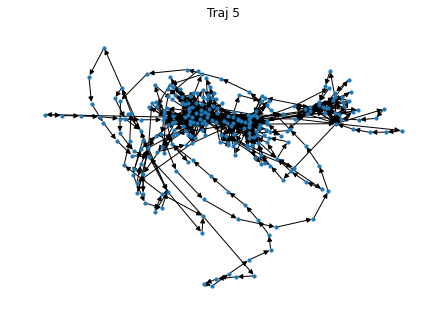

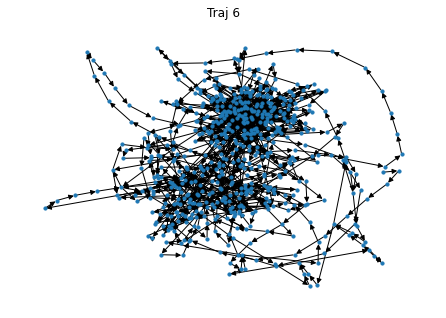

In [162]:
for ii in range(7):
    pos=nx.spring_layout(networks[ii])
    nx.draw(networks[ii], pos, node_size=10, with_labels=False)
    plt.title("Traj {}".format(ii))
    plt.show()